# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

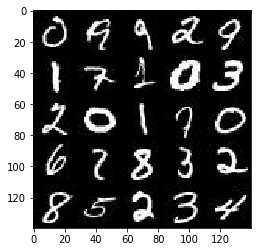

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

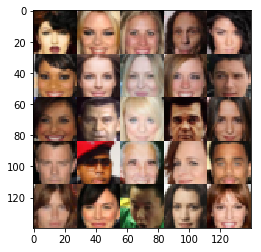

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs to the graph
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32,(None,image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learn_rate')
    
    # return None, None, None
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        
        alpha = 0.2
        
        # Input layer is 28x28x3  
        # print(images.get_shape().as_list())  # [None, 28, 28, 3]
        x1 = tf.layers.conv2d(images, 56, 5, strides=2, padding='same')
        
        relu1 = tf.maximum(alpha * x1, x1)
        # print(relu1.get_shape().as_list())  # [None, 14, 14, 56]
        
        x2 = tf.layers.conv2d(relu1, 112, 5, strides=2, padding='same')
        
        bn2 = tf.layers.batch_normalization(x2, training=True)
        
        relu2 = tf.maximum(alpha * bn2, bn2)
        # print(relu2.get_shape().as_list())  # [None, 7, 7, 112]
        
        # Flatten it
        flat = tf.reshape(relu2, (-1, 7*7*112)) #7*7*112, 7*7*256, 256*256*8
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    # return None, None
    return out, logits
"""
Leaky ReLU
TensorFlow doesn't provide an operation for leaky ReLUs, so we'll need to make one. For this 
you can use take the outputs from a linear fully connected layer and pass them to tf.maximum. 
Typically, a parameter alpha sets the magnitude of the output for negative values. So, the output 
for negative input (x) values is alpha*x, and the output for positive x is x:
f(x)=max(α∗x,x)
"""

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.2
    
    with tf.variable_scope('generator', reuse= not is_train):
        # First fully connected layer
        full_connected_layer1 = tf.layers.dense(z, 7*7*256)
        # print(full_connected_layer1.get_shape().as_list())  # [None, 12544]
        
        # Reshape it to start the convolutional stack
        fc1 = tf.reshape(full_connected_layer1, (-1, 7, 7, 256))
        fc1 = tf.layers.batch_normalization(fc1, training=is_train)
        reshape_fc1 = tf.nn.relu(fc1)
        # print(reshape_fc1.get_shape().as_list()) # [None, 14, 14, 128]
        
        # second layer 
        full_connected_layer2 = tf.layers.conv2d_transpose(reshape_fc1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(full_connected_layer2, training=is_train)
        fc2 = tf.maximum(alpha * x2, x2)
        # print(fc2.get_shape().as_list())  # [None, 28, 28, 5]
        
        # Remove third layer
       
        # output layer
        logits = tf.layers.conv2d_transpose(fc2, out_channel_dim, 5, strides=2, padding='same')
        out = tf.tanh(logits)
        # print(out.get_shape().as_list())
    return out

"""
Try to obtain shapes:
Reshape: (?, 4, 4, 256)
Second Layer: (?, 7, 7, 128)
Third Layer: (?, 14, 14, 64)
Output: (?, 28, 28, 5)
"""

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    
    # return None, None
    return d_loss, g_loss
    
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    vars = tf.trainable_variables()
    d_vars = [var for var in vars if var.name.startswith('discriminator')]
    g_vars = [var for var in vars if var.name.startswith('generator')]
    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]
    d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]

    with tf.control_dependencies(d_update_ops):
        d_train = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)

        
    with tf.control_dependencies(g_update_ops):
        g_train = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(g_loss, var_list = g_vars)

    # return None, None
    return d_train, g_train
"""
In practice enclosing all graph update ops as control dependencies may not be precise enough for that 
would include update ops in both the discriminator and generator.
That way the generator's update ops and the discriminator's update ops are distinguished clearly.
"""

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    # Inputs
    input_real, input_z, learning_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    # Loss
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    # Optimizers
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)   

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):                    
                steps += 1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate: 0.001})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, learning_rate: 0.001})

                if steps % 10 == 0:
                    print (steps/10)
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),     
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 1, input_z, data_shape[3], data_image_mode)         

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

1.0
Epoch 1/2... Discriminator Loss: 0.8750... Generator Loss: 5.3565
2.0
Epoch 1/2... Discriminator Loss: 0.8515... Generator Loss: 0.8492
3.0
Epoch 1/2... Discriminator Loss: 2.6084... Generator Loss: 0.1068
4.0
Epoch 1/2... Discriminator Loss: 1.8088... Generator Loss: 0.2789
5.0
Epoch 1/2... Discriminator Loss: 2.0225... Generator Loss: 0.2085
6.0
Epoch 1/2... Discriminator Loss: 1.8343... Generator Loss: 0.2420
7.0
Epoch 1/2... Discriminator Loss: 2.0029... Generator Loss: 0.2053
8.0
Epoch 1/2... Discriminator Loss: 1.8682... Generator Loss: 0.2502
9.0
Epoch 1/2... Discriminator Loss: 1.8332... Generator Loss: 0.2873
10.0
Epoch 1/2... Discriminator Loss: 1.6684... Generator Loss: 0.4212


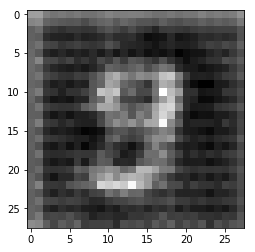

11.0
Epoch 1/2... Discriminator Loss: 1.5536... Generator Loss: 0.3762
12.0
Epoch 1/2... Discriminator Loss: 1.7124... Generator Loss: 0.2876
13.0
Epoch 1/2... Discriminator Loss: 1.5252... Generator Loss: 0.3895
14.0
Epoch 1/2... Discriminator Loss: 1.5173... Generator Loss: 0.3715
15.0
Epoch 1/2... Discriminator Loss: 1.6102... Generator Loss: 0.3348
16.0
Epoch 1/2... Discriminator Loss: 1.6426... Generator Loss: 0.3201
17.0
Epoch 1/2... Discriminator Loss: 1.5176... Generator Loss: 0.3856
18.0
Epoch 1/2... Discriminator Loss: 1.5140... Generator Loss: 0.3362
19.0
Epoch 1/2... Discriminator Loss: 1.3005... Generator Loss: 0.5415
20.0
Epoch 1/2... Discriminator Loss: 1.6275... Generator Loss: 0.3076


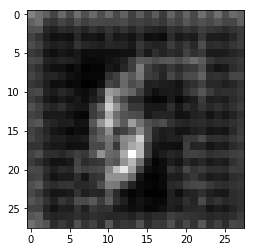

21.0
Epoch 1/2... Discriminator Loss: 1.3212... Generator Loss: 0.5927
22.0
Epoch 1/2... Discriminator Loss: 1.5583... Generator Loss: 0.3242
23.0
Epoch 1/2... Discriminator Loss: 1.4177... Generator Loss: 0.3970
24.0
Epoch 1/2... Discriminator Loss: 1.2212... Generator Loss: 0.6011
25.0
Epoch 1/2... Discriminator Loss: 1.5910... Generator Loss: 0.2968
26.0
Epoch 1/2... Discriminator Loss: 1.3908... Generator Loss: 0.4125
27.0
Epoch 1/2... Discriminator Loss: 1.4520... Generator Loss: 0.3731
28.0
Epoch 1/2... Discriminator Loss: 1.4493... Generator Loss: 0.3790
29.0
Epoch 1/2... Discriminator Loss: 1.3107... Generator Loss: 0.4876
30.0
Epoch 1/2... Discriminator Loss: 1.4271... Generator Loss: 0.4138


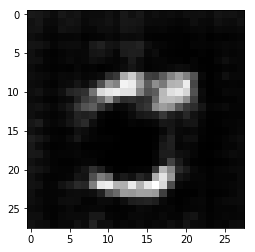

31.0
Epoch 1/2... Discriminator Loss: 1.4630... Generator Loss: 0.3745
32.0
Epoch 1/2... Discriminator Loss: 1.2846... Generator Loss: 0.5326
33.0
Epoch 1/2... Discriminator Loss: 1.4294... Generator Loss: 0.4090
34.0
Epoch 1/2... Discriminator Loss: 1.4627... Generator Loss: 0.3658
35.0
Epoch 1/2... Discriminator Loss: 1.1814... Generator Loss: 0.6176
36.0
Epoch 1/2... Discriminator Loss: 1.5428... Generator Loss: 0.3137
37.0
Epoch 1/2... Discriminator Loss: 1.5074... Generator Loss: 0.3514
38.0
Epoch 1/2... Discriminator Loss: 1.3497... Generator Loss: 0.4372
39.0
Epoch 1/2... Discriminator Loss: 1.4854... Generator Loss: 0.3844
40.0
Epoch 1/2... Discriminator Loss: 1.4590... Generator Loss: 0.3766


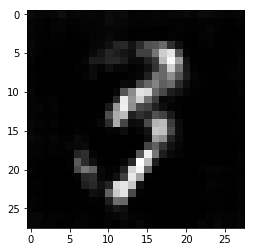

41.0
Epoch 1/2... Discriminator Loss: 1.5340... Generator Loss: 0.3166
42.0
Epoch 1/2... Discriminator Loss: 1.3686... Generator Loss: 0.5028
43.0
Epoch 1/2... Discriminator Loss: 1.4463... Generator Loss: 0.3701
44.0
Epoch 1/2... Discriminator Loss: 1.5523... Generator Loss: 0.3524
45.0
Epoch 1/2... Discriminator Loss: 1.4019... Generator Loss: 0.4240
46.0
Epoch 1/2... Discriminator Loss: 1.4570... Generator Loss: 0.3812
47.0
Epoch 1/2... Discriminator Loss: 1.3523... Generator Loss: 0.4969
48.0
Epoch 1/2... Discriminator Loss: 1.5136... Generator Loss: 0.3455
49.0
Epoch 1/2... Discriminator Loss: 1.6697... Generator Loss: 1.0635
50.0
Epoch 1/2... Discriminator Loss: 1.3287... Generator Loss: 0.7507


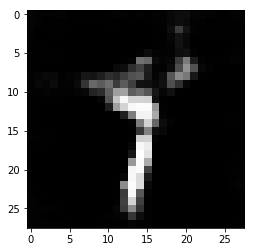

51.0
Epoch 1/2... Discriminator Loss: 1.3404... Generator Loss: 0.9775
52.0
Epoch 1/2... Discriminator Loss: 2.0500... Generator Loss: 1.8708
53.0
Epoch 1/2... Discriminator Loss: 1.3068... Generator Loss: 0.6369
54.0
Epoch 1/2... Discriminator Loss: 1.2409... Generator Loss: 0.8527
55.0
Epoch 1/2... Discriminator Loss: 1.5862... Generator Loss: 1.3735
56.0
Epoch 1/2... Discriminator Loss: 1.4182... Generator Loss: 1.0864
57.0
Epoch 1/2... Discriminator Loss: 1.4495... Generator Loss: 1.1251
58.0
Epoch 1/2... Discriminator Loss: 1.3017... Generator Loss: 0.6859
59.0
Epoch 1/2... Discriminator Loss: 1.5808... Generator Loss: 1.3786
60.0
Epoch 1/2... Discriminator Loss: 1.3632... Generator Loss: 0.7290


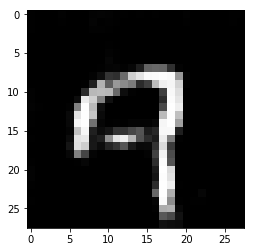

61.0
Epoch 1/2... Discriminator Loss: 1.3053... Generator Loss: 0.7076
62.0
Epoch 1/2... Discriminator Loss: 1.2565... Generator Loss: 0.8140
63.0
Epoch 1/2... Discriminator Loss: 1.3522... Generator Loss: 1.3426
64.0
Epoch 1/2... Discriminator Loss: 1.3797... Generator Loss: 1.1717
65.0
Epoch 1/2... Discriminator Loss: 1.2621... Generator Loss: 0.8115
66.0
Epoch 1/2... Discriminator Loss: 1.4322... Generator Loss: 1.1524
67.0
Epoch 1/2... Discriminator Loss: 1.2930... Generator Loss: 0.9186
68.0
Epoch 1/2... Discriminator Loss: 1.3680... Generator Loss: 0.9506
69.0
Epoch 1/2... Discriminator Loss: 1.1565... Generator Loss: 0.8010
70.0
Epoch 1/2... Discriminator Loss: 1.4724... Generator Loss: 1.2509


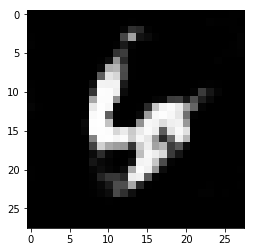

71.0
Epoch 1/2... Discriminator Loss: 1.2163... Generator Loss: 0.6787
72.0
Epoch 1/2... Discriminator Loss: 1.2604... Generator Loss: 0.8326
73.0
Epoch 1/2... Discriminator Loss: 1.4010... Generator Loss: 1.0216
74.0
Epoch 1/2... Discriminator Loss: 1.4226... Generator Loss: 1.0900
75.0
Epoch 1/2... Discriminator Loss: 1.1997... Generator Loss: 0.7590
76.0
Epoch 1/2... Discriminator Loss: 1.5879... Generator Loss: 1.4975
77.0
Epoch 1/2... Discriminator Loss: 1.2147... Generator Loss: 0.9518
78.0
Epoch 1/2... Discriminator Loss: 1.3896... Generator Loss: 0.9369
79.0
Epoch 1/2... Discriminator Loss: 1.2473... Generator Loss: 0.7477
80.0
Epoch 1/2... Discriminator Loss: 1.9596... Generator Loss: 1.7902


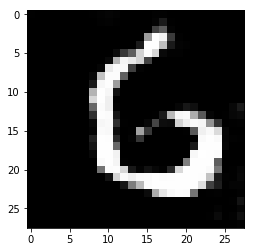

81.0
Epoch 1/2... Discriminator Loss: 1.1916... Generator Loss: 0.7914
82.0
Epoch 1/2... Discriminator Loss: 1.2119... Generator Loss: 0.8695
83.0
Epoch 1/2... Discriminator Loss: 2.0234... Generator Loss: 2.0274
84.0
Epoch 1/2... Discriminator Loss: 1.2203... Generator Loss: 0.8056
85.0
Epoch 1/2... Discriminator Loss: 1.2658... Generator Loss: 1.0691
86.0
Epoch 1/2... Discriminator Loss: 1.2787... Generator Loss: 1.0837
87.0
Epoch 1/2... Discriminator Loss: 1.2487... Generator Loss: 1.0384
88.0
Epoch 1/2... Discriminator Loss: 1.2297... Generator Loss: 0.5982
89.0
Epoch 1/2... Discriminator Loss: 1.9674... Generator Loss: 1.6664
90.0
Epoch 1/2... Discriminator Loss: 1.2899... Generator Loss: 0.9582


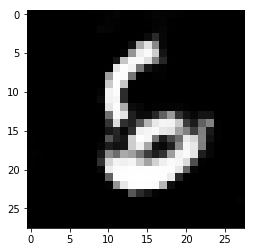

91.0
Epoch 1/2... Discriminator Loss: 1.4004... Generator Loss: 0.9735
92.0
Epoch 1/2... Discriminator Loss: 1.1115... Generator Loss: 0.9476
93.0
Epoch 1/2... Discriminator Loss: 1.2076... Generator Loss: 0.9029
1.0
Epoch 2/2... Discriminator Loss: 1.2984... Generator Loss: 0.6504
2.0
Epoch 2/2... Discriminator Loss: 1.3417... Generator Loss: 0.4717
3.0
Epoch 2/2... Discriminator Loss: 1.5122... Generator Loss: 0.3804
4.0
Epoch 2/2... Discriminator Loss: 1.2904... Generator Loss: 0.5331
5.0
Epoch 2/2... Discriminator Loss: 1.5034... Generator Loss: 0.3461
6.0
Epoch 2/2... Discriminator Loss: 1.2362... Generator Loss: 1.0538
7.0
Epoch 2/2... Discriminator Loss: 1.2808... Generator Loss: 0.8082
8.0
Epoch 2/2... Discriminator Loss: 1.2736... Generator Loss: 0.6179
9.0
Epoch 2/2... Discriminator Loss: 1.5316... Generator Loss: 1.4968
10.0
Epoch 2/2... Discriminator Loss: 1.3154... Generator Loss: 0.9805


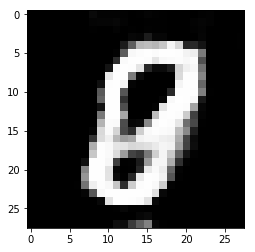

11.0
Epoch 2/2... Discriminator Loss: 1.2516... Generator Loss: 1.1747
12.0
Epoch 2/2... Discriminator Loss: 1.2362... Generator Loss: 1.0454
13.0
Epoch 2/2... Discriminator Loss: 1.2664... Generator Loss: 0.9480
14.0
Epoch 2/2... Discriminator Loss: 1.2628... Generator Loss: 0.9164
15.0
Epoch 2/2... Discriminator Loss: 1.2894... Generator Loss: 0.6018
16.0
Epoch 2/2... Discriminator Loss: 1.5394... Generator Loss: 0.3433
17.0
Epoch 2/2... Discriminator Loss: 1.3639... Generator Loss: 0.4492
18.0
Epoch 2/2... Discriminator Loss: 1.3666... Generator Loss: 0.4102
19.0
Epoch 2/2... Discriminator Loss: 1.4579... Generator Loss: 0.4050
20.0
Epoch 2/2... Discriminator Loss: 1.1984... Generator Loss: 0.8199


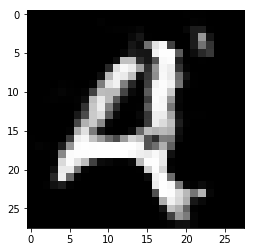

21.0
Epoch 2/2... Discriminator Loss: 1.2294... Generator Loss: 1.1401
22.0
Epoch 2/2... Discriminator Loss: 1.1984... Generator Loss: 0.8761
23.0
Epoch 2/2... Discriminator Loss: 1.5484... Generator Loss: 1.5174
24.0
Epoch 2/2... Discriminator Loss: 1.1962... Generator Loss: 0.8244
25.0
Epoch 2/2... Discriminator Loss: 1.2720... Generator Loss: 0.9530
26.0
Epoch 2/2... Discriminator Loss: 1.4417... Generator Loss: 1.3941
27.0
Epoch 2/2... Discriminator Loss: 1.1244... Generator Loss: 0.6487
28.0
Epoch 2/2... Discriminator Loss: 1.3098... Generator Loss: 0.4462
29.0
Epoch 2/2... Discriminator Loss: 1.3512... Generator Loss: 0.4053
30.0
Epoch 2/2... Discriminator Loss: 1.3137... Generator Loss: 0.5087


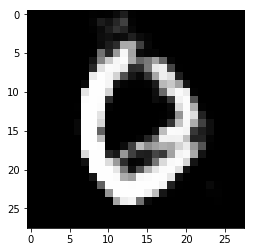

31.0
Epoch 2/2... Discriminator Loss: 1.4937... Generator Loss: 0.3889
32.0
Epoch 2/2... Discriminator Loss: 1.1681... Generator Loss: 0.8444
33.0
Epoch 2/2... Discriminator Loss: 1.1286... Generator Loss: 1.0060
34.0
Epoch 2/2... Discriminator Loss: 1.2712... Generator Loss: 0.7096
35.0
Epoch 2/2... Discriminator Loss: 1.6850... Generator Loss: 1.6237
36.0
Epoch 2/2... Discriminator Loss: 1.2052... Generator Loss: 1.0963
37.0
Epoch 2/2... Discriminator Loss: 1.2224... Generator Loss: 0.6175
38.0
Epoch 2/2... Discriminator Loss: 1.9338... Generator Loss: 2.1668
39.0
Epoch 2/2... Discriminator Loss: 1.2702... Generator Loss: 1.0321
40.0
Epoch 2/2... Discriminator Loss: 1.1960... Generator Loss: 1.1615


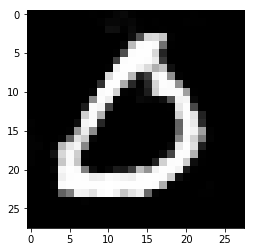

41.0
Epoch 2/2... Discriminator Loss: 1.2614... Generator Loss: 0.5237
42.0
Epoch 2/2... Discriminator Loss: 1.1820... Generator Loss: 0.6741
43.0
Epoch 2/2... Discriminator Loss: 1.2686... Generator Loss: 0.9553
44.0
Epoch 2/2... Discriminator Loss: 1.7249... Generator Loss: 1.7070
45.0
Epoch 2/2... Discriminator Loss: 1.2534... Generator Loss: 0.8335
46.0
Epoch 2/2... Discriminator Loss: 1.3273... Generator Loss: 1.4399
47.0
Epoch 2/2... Discriminator Loss: 1.7008... Generator Loss: 0.2775
48.0
Epoch 2/2... Discriminator Loss: 1.1742... Generator Loss: 0.6501
49.0
Epoch 2/2... Discriminator Loss: 2.1952... Generator Loss: 2.2415
50.0
Epoch 2/2... Discriminator Loss: 1.0937... Generator Loss: 0.7798


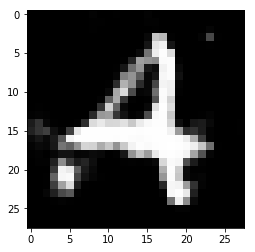

51.0
Epoch 2/2... Discriminator Loss: 1.4147... Generator Loss: 0.4146
52.0
Epoch 2/2... Discriminator Loss: 1.2146... Generator Loss: 1.1886
53.0
Epoch 2/2... Discriminator Loss: 1.1912... Generator Loss: 0.5872
54.0
Epoch 2/2... Discriminator Loss: 1.1028... Generator Loss: 0.7009
55.0
Epoch 2/2... Discriminator Loss: 1.0582... Generator Loss: 0.8678
56.0
Epoch 2/2... Discriminator Loss: 1.2275... Generator Loss: 0.9100
57.0
Epoch 2/2... Discriminator Loss: 1.3152... Generator Loss: 1.1438
58.0
Epoch 2/2... Discriminator Loss: 1.3721... Generator Loss: 1.1166
59.0
Epoch 2/2... Discriminator Loss: 1.2932... Generator Loss: 0.6269
60.0
Epoch 2/2... Discriminator Loss: 1.7168... Generator Loss: 0.2482


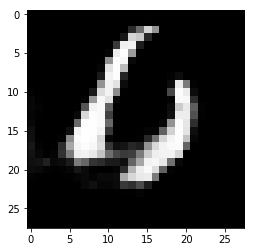

61.0
Epoch 2/2... Discriminator Loss: 1.2199... Generator Loss: 0.5966
62.0
Epoch 2/2... Discriminator Loss: 1.1265... Generator Loss: 0.6629
63.0
Epoch 2/2... Discriminator Loss: 1.4463... Generator Loss: 1.7395
64.0
Epoch 2/2... Discriminator Loss: 1.2363... Generator Loss: 1.2476
65.0
Epoch 2/2... Discriminator Loss: 1.5045... Generator Loss: 0.3206
66.0
Epoch 2/2... Discriminator Loss: 1.7353... Generator Loss: 0.2410
67.0
Epoch 2/2... Discriminator Loss: 1.1183... Generator Loss: 0.6372
68.0
Epoch 2/2... Discriminator Loss: 1.6915... Generator Loss: 0.2703
69.0
Epoch 2/2... Discriminator Loss: 1.3416... Generator Loss: 0.4239
70.0
Epoch 2/2... Discriminator Loss: 1.1058... Generator Loss: 0.7555


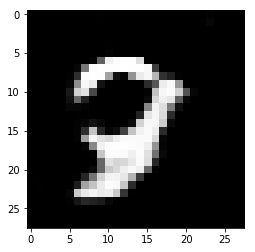

71.0
Epoch 2/2... Discriminator Loss: 1.1133... Generator Loss: 0.7438
72.0
Epoch 2/2... Discriminator Loss: 1.6085... Generator Loss: 0.3308
73.0
Epoch 2/2... Discriminator Loss: 1.3500... Generator Loss: 0.4523
74.0
Epoch 2/2... Discriminator Loss: 1.2706... Generator Loss: 0.4928
75.0
Epoch 2/2... Discriminator Loss: 1.3466... Generator Loss: 0.4215
76.0
Epoch 2/2... Discriminator Loss: 1.4192... Generator Loss: 0.4022
77.0
Epoch 2/2... Discriminator Loss: 1.0297... Generator Loss: 0.8656
78.0
Epoch 2/2... Discriminator Loss: 1.4419... Generator Loss: 0.4055
79.0
Epoch 2/2... Discriminator Loss: 1.1425... Generator Loss: 0.6735
80.0
Epoch 2/2... Discriminator Loss: 1.2002... Generator Loss: 0.5377


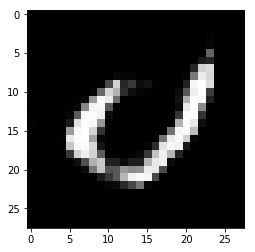

81.0
Epoch 2/2... Discriminator Loss: 1.6139... Generator Loss: 0.2845
82.0
Epoch 2/2... Discriminator Loss: 1.2342... Generator Loss: 0.5828
83.0
Epoch 2/2... Discriminator Loss: 1.0653... Generator Loss: 0.7617
84.0
Epoch 2/2... Discriminator Loss: 1.4966... Generator Loss: 1.6466
85.0
Epoch 2/2... Discriminator Loss: 1.1643... Generator Loss: 0.6400
86.0
Epoch 2/2... Discriminator Loss: 1.2235... Generator Loss: 0.5021
87.0
Epoch 2/2... Discriminator Loss: 1.1015... Generator Loss: 0.6474
88.0
Epoch 2/2... Discriminator Loss: 1.5192... Generator Loss: 0.3398
89.0
Epoch 2/2... Discriminator Loss: 1.1820... Generator Loss: 0.6513
90.0
Epoch 2/2... Discriminator Loss: 1.1893... Generator Loss: 1.1784


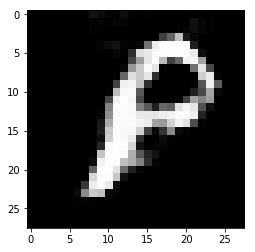

91.0
Epoch 2/2... Discriminator Loss: 1.3281... Generator Loss: 0.4995
92.0
Epoch 2/2... Discriminator Loss: 1.3174... Generator Loss: 0.4083
93.0
Epoch 2/2... Discriminator Loss: 1.3306... Generator Loss: 0.4648


In [12]:
# batch_size = None
batch_size = 64
# z_dim = None
z_dim = 64
# learning_rate = None
learning_rate = 0.001
# beta1 = None
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

1.0
Epoch 1/1... Discriminator Loss: 3.7926... Generator Loss: 0.0432
2.0
Epoch 1/1... Discriminator Loss: 4.3587... Generator Loss: 0.0202
3.0
Epoch 1/1... Discriminator Loss: 3.0323... Generator Loss: 0.0799
4.0
Epoch 1/1... Discriminator Loss: 1.6041... Generator Loss: 0.4338
5.0
Epoch 1/1... Discriminator Loss: 1.6279... Generator Loss: 0.3263
6.0
Epoch 1/1... Discriminator Loss: 2.4936... Generator Loss: 0.1222
7.0
Epoch 1/1... Discriminator Loss: 2.0706... Generator Loss: 0.1949
8.0
Epoch 1/1... Discriminator Loss: 1.3294... Generator Loss: 0.5037
9.0
Epoch 1/1... Discriminator Loss: 2.0670... Generator Loss: 0.1791
10.0
Epoch 1/1... Discriminator Loss: 1.8643... Generator Loss: 0.2189


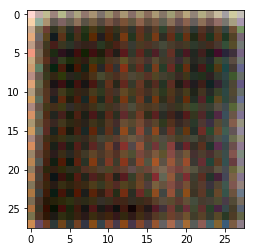

11.0
Epoch 1/1... Discriminator Loss: 1.7511... Generator Loss: 0.2658
12.0
Epoch 1/1... Discriminator Loss: 1.0270... Generator Loss: 0.6097
13.0
Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.3814
14.0
Epoch 1/1... Discriminator Loss: 1.8878... Generator Loss: 0.2203
15.0
Epoch 1/1... Discriminator Loss: 1.7277... Generator Loss: 0.2494
16.0
Epoch 1/1... Discriminator Loss: 2.4693... Generator Loss: 0.1022
17.0
Epoch 1/1... Discriminator Loss: 1.0933... Generator Loss: 0.5288
18.0
Epoch 1/1... Discriminator Loss: 1.0003... Generator Loss: 0.5488
19.0
Epoch 1/1... Discriminator Loss: 0.4214... Generator Loss: 1.2184
20.0
Epoch 1/1... Discriminator Loss: 0.6930... Generator Loss: 5.5160


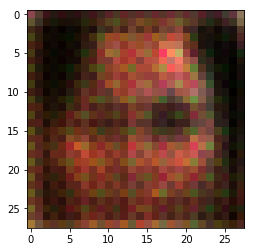

21.0
Epoch 1/1... Discriminator Loss: 0.7736... Generator Loss: 4.7521
22.0
Epoch 1/1... Discriminator Loss: 1.4970... Generator Loss: 0.4961
23.0
Epoch 1/1... Discriminator Loss: 0.9921... Generator Loss: 0.7203
24.0
Epoch 1/1... Discriminator Loss: 0.4745... Generator Loss: 1.7342
25.0
Epoch 1/1... Discriminator Loss: 1.2490... Generator Loss: 0.4266
26.0
Epoch 1/1... Discriminator Loss: 1.4920... Generator Loss: 1.1332
27.0
Epoch 1/1... Discriminator Loss: 1.4439... Generator Loss: 0.5703
28.0
Epoch 1/1... Discriminator Loss: 1.0182... Generator Loss: 1.0268
29.0
Epoch 1/1... Discriminator Loss: 1.5382... Generator Loss: 0.7400
30.0
Epoch 1/1... Discriminator Loss: 1.2625... Generator Loss: 0.7945


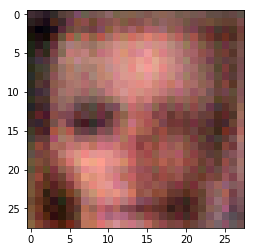

31.0
Epoch 1/1... Discriminator Loss: 0.7175... Generator Loss: 2.7596
32.0
Epoch 1/1... Discriminator Loss: 1.0664... Generator Loss: 3.1497
33.0
Epoch 1/1... Discriminator Loss: 1.1899... Generator Loss: 0.9769
34.0
Epoch 1/1... Discriminator Loss: 1.2942... Generator Loss: 2.4057
35.0
Epoch 1/1... Discriminator Loss: 1.0420... Generator Loss: 1.1493
36.0
Epoch 1/1... Discriminator Loss: 1.8009... Generator Loss: 1.7074
37.0
Epoch 1/1... Discriminator Loss: 1.7184... Generator Loss: 1.3507
38.0
Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.4424
39.0
Epoch 1/1... Discriminator Loss: 1.4487... Generator Loss: 1.8081
40.0
Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 0.4157


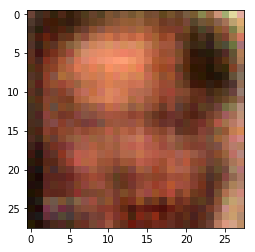

41.0
Epoch 1/1... Discriminator Loss: 1.0371... Generator Loss: 0.8958
42.0
Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.6832
43.0
Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.8810
44.0
Epoch 1/1... Discriminator Loss: 1.8927... Generator Loss: 0.2176
45.0
Epoch 1/1... Discriminator Loss: 1.1728... Generator Loss: 0.7644
46.0
Epoch 1/1... Discriminator Loss: 0.8557... Generator Loss: 0.9835
47.0
Epoch 1/1... Discriminator Loss: 1.4333... Generator Loss: 0.6993
48.0
Epoch 1/1... Discriminator Loss: 1.3024... Generator Loss: 1.3466
49.0
Epoch 1/1... Discriminator Loss: 2.0140... Generator Loss: 0.1699
50.0
Epoch 1/1... Discriminator Loss: 1.0598... Generator Loss: 1.6651


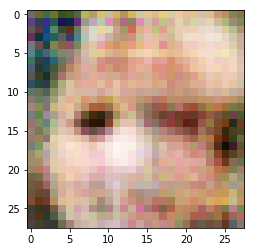

51.0
Epoch 1/1... Discriminator Loss: 1.6128... Generator Loss: 2.1522
52.0
Epoch 1/1... Discriminator Loss: 1.6572... Generator Loss: 0.3529
53.0
Epoch 1/1... Discriminator Loss: 1.2517... Generator Loss: 0.6348
54.0
Epoch 1/1... Discriminator Loss: 1.1163... Generator Loss: 1.4545
55.0
Epoch 1/1... Discriminator Loss: 1.4884... Generator Loss: 1.2689
56.0
Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 0.5157
57.0
Epoch 1/1... Discriminator Loss: 1.1917... Generator Loss: 0.6281
58.0
Epoch 1/1... Discriminator Loss: 1.6427... Generator Loss: 0.3199
59.0
Epoch 1/1... Discriminator Loss: 1.4923... Generator Loss: 0.3582
60.0
Epoch 1/1... Discriminator Loss: 1.5568... Generator Loss: 0.3151


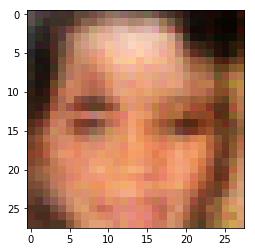

61.0
Epoch 1/1... Discriminator Loss: 0.5202... Generator Loss: 1.4189
62.0
Epoch 1/1... Discriminator Loss: 1.2660... Generator Loss: 0.4052
63.0
Epoch 1/1... Discriminator Loss: 1.3975... Generator Loss: 0.8926
64.0
Epoch 1/1... Discriminator Loss: 1.0222... Generator Loss: 0.7227
65.0
Epoch 1/1... Discriminator Loss: 1.1386... Generator Loss: 0.8341
66.0
Epoch 1/1... Discriminator Loss: 1.2091... Generator Loss: 2.3042
67.0
Epoch 1/1... Discriminator Loss: 0.6237... Generator Loss: 1.1843
68.0
Epoch 1/1... Discriminator Loss: 0.4206... Generator Loss: 3.1839
69.0
Epoch 1/1... Discriminator Loss: 1.0335... Generator Loss: 2.7508
70.0
Epoch 1/1... Discriminator Loss: 0.8764... Generator Loss: 0.7637


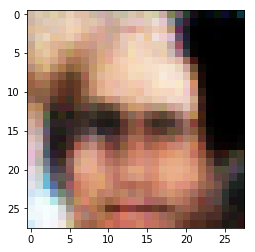

71.0
Epoch 1/1... Discriminator Loss: 0.2518... Generator Loss: 4.8019
72.0
Epoch 1/1... Discriminator Loss: 0.7458... Generator Loss: 1.7113
73.0
Epoch 1/1... Discriminator Loss: 0.1394... Generator Loss: 4.5062
74.0
Epoch 1/1... Discriminator Loss: 1.6873... Generator Loss: 1.6597
75.0
Epoch 1/1... Discriminator Loss: 0.5595... Generator Loss: 3.3697
76.0
Epoch 1/1... Discriminator Loss: 1.0455... Generator Loss: 2.4348
77.0
Epoch 1/1... Discriminator Loss: 1.5119... Generator Loss: 2.5073
78.0
Epoch 1/1... Discriminator Loss: 0.3532... Generator Loss: 1.7782
79.0
Epoch 1/1... Discriminator Loss: 0.2171... Generator Loss: 2.5842
80.0
Epoch 1/1... Discriminator Loss: 0.5409... Generator Loss: 6.0674


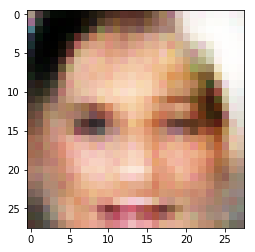

81.0
Epoch 1/1... Discriminator Loss: 0.7561... Generator Loss: 1.7528
82.0
Epoch 1/1... Discriminator Loss: 0.3203... Generator Loss: 1.7121
83.0
Epoch 1/1... Discriminator Loss: 0.2421... Generator Loss: 2.1323
84.0
Epoch 1/1... Discriminator Loss: 1.7812... Generator Loss: 0.3423
85.0
Epoch 1/1... Discriminator Loss: 1.1573... Generator Loss: 0.5584
86.0
Epoch 1/1... Discriminator Loss: 0.9368... Generator Loss: 0.7399
87.0
Epoch 1/1... Discriminator Loss: 1.1396... Generator Loss: 0.7515
88.0
Epoch 1/1... Discriminator Loss: 0.8430... Generator Loss: 1.4813
89.0
Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 1.6026
90.0
Epoch 1/1... Discriminator Loss: 1.7431... Generator Loss: 2.4192


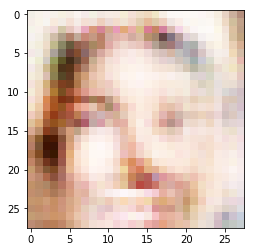

91.0
Epoch 1/1... Discriminator Loss: 1.2111... Generator Loss: 2.0388
92.0
Epoch 1/1... Discriminator Loss: 1.7297... Generator Loss: 2.2652
93.0
Epoch 1/1... Discriminator Loss: 1.1557... Generator Loss: 0.9189
94.0
Epoch 1/1... Discriminator Loss: 0.8266... Generator Loss: 1.2022
95.0
Epoch 1/1... Discriminator Loss: 0.4605... Generator Loss: 1.2714
96.0
Epoch 1/1... Discriminator Loss: 0.5156... Generator Loss: 1.1787
97.0
Epoch 1/1... Discriminator Loss: 2.0960... Generator Loss: 2.7412
98.0
Epoch 1/1... Discriminator Loss: 1.7385... Generator Loss: 0.2456
99.0
Epoch 1/1... Discriminator Loss: 1.6917... Generator Loss: 0.3009
100.0
Epoch 1/1... Discriminator Loss: 0.7188... Generator Loss: 1.1603


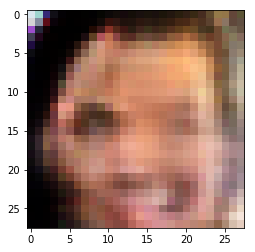

101.0
Epoch 1/1... Discriminator Loss: 0.4151... Generator Loss: 2.4201
102.0
Epoch 1/1... Discriminator Loss: 0.2737... Generator Loss: 1.9288
103.0
Epoch 1/1... Discriminator Loss: 0.9367... Generator Loss: 2.4004
104.0
Epoch 1/1... Discriminator Loss: 1.8178... Generator Loss: 1.7734
105.0
Epoch 1/1... Discriminator Loss: 0.2132... Generator Loss: 2.4833
106.0
Epoch 1/1... Discriminator Loss: 0.6880... Generator Loss: 1.3517
107.0
Epoch 1/1... Discriminator Loss: 0.7420... Generator Loss: 1.5543
108.0
Epoch 1/1... Discriminator Loss: 1.5372... Generator Loss: 1.5470
109.0
Epoch 1/1... Discriminator Loss: 0.9653... Generator Loss: 1.5840
110.0
Epoch 1/1... Discriminator Loss: 1.3017... Generator Loss: 1.3610


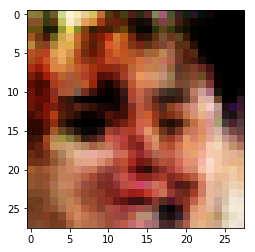

111.0
Epoch 1/1... Discriminator Loss: 0.9603... Generator Loss: 1.1622
112.0
Epoch 1/1... Discriminator Loss: 0.7213... Generator Loss: 4.5850
113.0
Epoch 1/1... Discriminator Loss: 0.2085... Generator Loss: 2.3033
114.0
Epoch 1/1... Discriminator Loss: 0.8437... Generator Loss: 0.9387
115.0
Epoch 1/1... Discriminator Loss: 0.4173... Generator Loss: 1.8060
116.0
Epoch 1/1... Discriminator Loss: 0.8532... Generator Loss: 1.9880
117.0
Epoch 1/1... Discriminator Loss: 1.2655... Generator Loss: 0.5165
118.0
Epoch 1/1... Discriminator Loss: 0.5756... Generator Loss: 1.1908
119.0
Epoch 1/1... Discriminator Loss: 0.9090... Generator Loss: 0.7821
120.0
Epoch 1/1... Discriminator Loss: 0.5558... Generator Loss: 1.1238


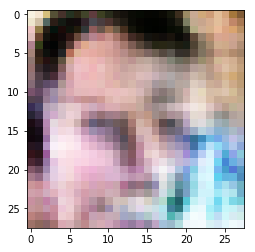

121.0
Epoch 1/1... Discriminator Loss: 0.1920... Generator Loss: 5.1001
122.0
Epoch 1/1... Discriminator Loss: 0.5534... Generator Loss: 3.0189
123.0
Epoch 1/1... Discriminator Loss: 2.1075... Generator Loss: 0.1604
124.0
Epoch 1/1... Discriminator Loss: 1.3224... Generator Loss: 0.4580
125.0
Epoch 1/1... Discriminator Loss: 1.7826... Generator Loss: 1.8627
126.0
Epoch 1/1... Discriminator Loss: 1.2656... Generator Loss: 0.5067
127.0
Epoch 1/1... Discriminator Loss: 1.3593... Generator Loss: 0.7029
128.0
Epoch 1/1... Discriminator Loss: 1.0716... Generator Loss: 1.2630
129.0
Epoch 1/1... Discriminator Loss: 0.9093... Generator Loss: 1.6243
130.0
Epoch 1/1... Discriminator Loss: 1.0552... Generator Loss: 1.7948


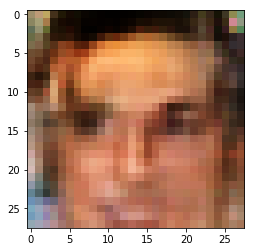

131.0
Epoch 1/1... Discriminator Loss: 0.8867... Generator Loss: 1.8644
132.0
Epoch 1/1... Discriminator Loss: 1.0661... Generator Loss: 0.8535
133.0
Epoch 1/1... Discriminator Loss: 1.2320... Generator Loss: 1.5109
134.0
Epoch 1/1... Discriminator Loss: 0.9873... Generator Loss: 1.5746
135.0
Epoch 1/1... Discriminator Loss: 0.9952... Generator Loss: 0.8523
136.0
Epoch 1/1... Discriminator Loss: 1.2703... Generator Loss: 0.5516
137.0
Epoch 1/1... Discriminator Loss: 1.4808... Generator Loss: 0.3561
138.0
Epoch 1/1... Discriminator Loss: 0.9108... Generator Loss: 0.8485
139.0
Epoch 1/1... Discriminator Loss: 1.1324... Generator Loss: 0.7040
140.0
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.4338


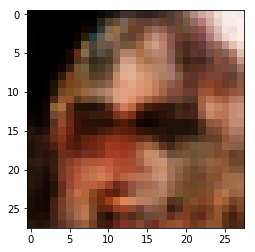

141.0
Epoch 1/1... Discriminator Loss: 0.7797... Generator Loss: 1.0286
142.0
Epoch 1/1... Discriminator Loss: 0.8321... Generator Loss: 1.4400
143.0
Epoch 1/1... Discriminator Loss: 0.6268... Generator Loss: 1.2542
144.0
Epoch 1/1... Discriminator Loss: 1.1263... Generator Loss: 1.0804
145.0
Epoch 1/1... Discriminator Loss: 1.0987... Generator Loss: 0.5855
146.0
Epoch 1/1... Discriminator Loss: 1.5655... Generator Loss: 0.4155
147.0
Epoch 1/1... Discriminator Loss: 1.0533... Generator Loss: 1.2048
148.0
Epoch 1/1... Discriminator Loss: 0.8201... Generator Loss: 1.4819
149.0
Epoch 1/1... Discriminator Loss: 1.5106... Generator Loss: 1.8529
150.0
Epoch 1/1... Discriminator Loss: 1.0941... Generator Loss: 0.7803


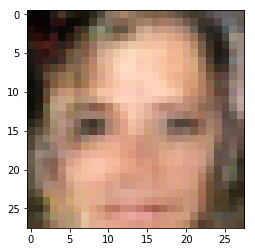

151.0
Epoch 1/1... Discriminator Loss: 0.8927... Generator Loss: 1.0540
152.0
Epoch 1/1... Discriminator Loss: 1.1807... Generator Loss: 0.8331
153.0
Epoch 1/1... Discriminator Loss: 1.1788... Generator Loss: 1.2036
154.0
Epoch 1/1... Discriminator Loss: 0.9742... Generator Loss: 1.5526
155.0
Epoch 1/1... Discriminator Loss: 1.0563... Generator Loss: 0.9792
156.0
Epoch 1/1... Discriminator Loss: 1.1574... Generator Loss: 0.6581
157.0
Epoch 1/1... Discriminator Loss: 0.2198... Generator Loss: 2.4376
158.0
Epoch 1/1... Discriminator Loss: 1.0796... Generator Loss: 1.4090
159.0
Epoch 1/1... Discriminator Loss: 1.6970... Generator Loss: 1.6320
160.0
Epoch 1/1... Discriminator Loss: 0.5442... Generator Loss: 1.6991


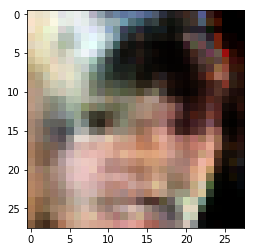

161.0
Epoch 1/1... Discriminator Loss: 1.0791... Generator Loss: 1.3885
162.0
Epoch 1/1... Discriminator Loss: 1.2955... Generator Loss: 2.0353
163.0
Epoch 1/1... Discriminator Loss: 1.0204... Generator Loss: 1.4744
164.0
Epoch 1/1... Discriminator Loss: 0.8345... Generator Loss: 1.8674
165.0
Epoch 1/1... Discriminator Loss: 0.1713... Generator Loss: 2.9774
166.0
Epoch 1/1... Discriminator Loss: 1.8390... Generator Loss: 2.3626
167.0
Epoch 1/1... Discriminator Loss: 0.8172... Generator Loss: 1.7993
168.0
Epoch 1/1... Discriminator Loss: 1.1601... Generator Loss: 0.6061
169.0
Epoch 1/1... Discriminator Loss: 0.3590... Generator Loss: 1.7013
170.0
Epoch 1/1... Discriminator Loss: 0.3854... Generator Loss: 1.4772


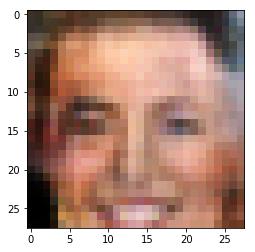

171.0
Epoch 1/1... Discriminator Loss: 0.1462... Generator Loss: 2.5921
172.0
Epoch 1/1... Discriminator Loss: 0.7890... Generator Loss: 1.0100
173.0
Epoch 1/1... Discriminator Loss: 0.8241... Generator Loss: 0.9526
174.0
Epoch 1/1... Discriminator Loss: 2.1082... Generator Loss: 2.7897
175.0
Epoch 1/1... Discriminator Loss: 1.2677... Generator Loss: 0.5363
176.0
Epoch 1/1... Discriminator Loss: 0.9416... Generator Loss: 1.0518
177.0
Epoch 1/1... Discriminator Loss: 2.0271... Generator Loss: 2.0153
178.0
Epoch 1/1... Discriminator Loss: 1.1409... Generator Loss: 0.9922
179.0
Epoch 1/1... Discriminator Loss: 1.4847... Generator Loss: 1.3017
180.0
Epoch 1/1... Discriminator Loss: 0.8939... Generator Loss: 1.1353


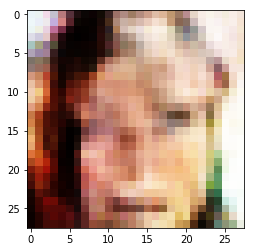

181.0
Epoch 1/1... Discriminator Loss: 1.0195... Generator Loss: 1.0065
182.0
Epoch 1/1... Discriminator Loss: 0.6634... Generator Loss: 1.4830
183.0
Epoch 1/1... Discriminator Loss: 0.1205... Generator Loss: 5.0353
184.0
Epoch 1/1... Discriminator Loss: 0.3300... Generator Loss: 2.1407
185.0
Epoch 1/1... Discriminator Loss: 0.1365... Generator Loss: 3.3687
186.0
Epoch 1/1... Discriminator Loss: 1.1595... Generator Loss: 1.7852
187.0
Epoch 1/1... Discriminator Loss: 1.5184... Generator Loss: 4.8019
188.0
Epoch 1/1... Discriminator Loss: 0.9330... Generator Loss: 1.3435
189.0
Epoch 1/1... Discriminator Loss: 1.9609... Generator Loss: 2.0552
190.0
Epoch 1/1... Discriminator Loss: 0.9194... Generator Loss: 2.1683


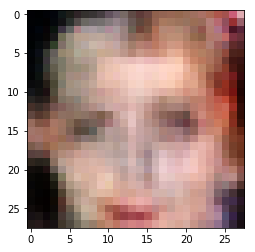

191.0
Epoch 1/1... Discriminator Loss: 1.0423... Generator Loss: 1.0028
192.0
Epoch 1/1... Discriminator Loss: 1.4950... Generator Loss: 0.3491
193.0
Epoch 1/1... Discriminator Loss: 1.0149... Generator Loss: 0.7782
194.0
Epoch 1/1... Discriminator Loss: 1.2445... Generator Loss: 0.5110
195.0
Epoch 1/1... Discriminator Loss: 0.7048... Generator Loss: 1.1431
196.0
Epoch 1/1... Discriminator Loss: 1.6260... Generator Loss: 1.7217
197.0
Epoch 1/1... Discriminator Loss: 0.7868... Generator Loss: 1.8975
198.0
Epoch 1/1... Discriminator Loss: 1.2960... Generator Loss: 1.5024
199.0
Epoch 1/1... Discriminator Loss: 1.2491... Generator Loss: 0.6218
200.0
Epoch 1/1... Discriminator Loss: 0.8909... Generator Loss: 0.8590


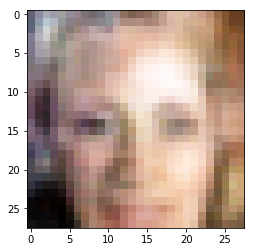

201.0
Epoch 1/1... Discriminator Loss: 1.5464... Generator Loss: 0.3548
202.0
Epoch 1/1... Discriminator Loss: 1.1557... Generator Loss: 0.7167
203.0
Epoch 1/1... Discriminator Loss: 0.9431... Generator Loss: 2.0144
204.0
Epoch 1/1... Discriminator Loss: 1.1957... Generator Loss: 1.1599
205.0
Epoch 1/1... Discriminator Loss: 0.6725... Generator Loss: 1.2163
206.0
Epoch 1/1... Discriminator Loss: 0.2600... Generator Loss: 4.9146
207.0
Epoch 1/1... Discriminator Loss: 0.9038... Generator Loss: 0.7126
208.0
Epoch 1/1... Discriminator Loss: 1.1439... Generator Loss: 0.6293
209.0
Epoch 1/1... Discriminator Loss: 1.3116... Generator Loss: 0.5707
210.0
Epoch 1/1... Discriminator Loss: 1.0134... Generator Loss: 0.9912


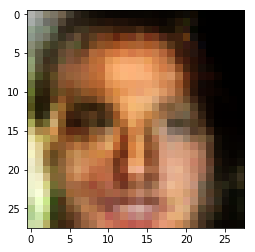

211.0
Epoch 1/1... Discriminator Loss: 1.3164... Generator Loss: 0.4483
212.0
Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.4218
213.0
Epoch 1/1... Discriminator Loss: 1.1251... Generator Loss: 0.5476
214.0
Epoch 1/1... Discriminator Loss: 0.9856... Generator Loss: 1.4142
215.0
Epoch 1/1... Discriminator Loss: 0.9533... Generator Loss: 1.4481
216.0
Epoch 1/1... Discriminator Loss: 1.0383... Generator Loss: 1.2105
217.0
Epoch 1/1... Discriminator Loss: 1.1005... Generator Loss: 1.3194
218.0
Epoch 1/1... Discriminator Loss: 0.8967... Generator Loss: 0.9915
219.0
Epoch 1/1... Discriminator Loss: 0.2890... Generator Loss: 1.9163
220.0
Epoch 1/1... Discriminator Loss: 1.4478... Generator Loss: 0.3892


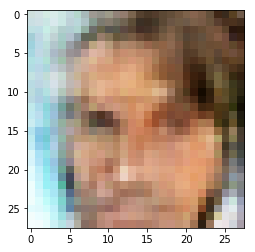

221.0
Epoch 1/1... Discriminator Loss: 1.2308... Generator Loss: 0.6433
222.0
Epoch 1/1... Discriminator Loss: 0.8060... Generator Loss: 0.9578
223.0
Epoch 1/1... Discriminator Loss: 1.3149... Generator Loss: 0.5887
224.0
Epoch 1/1... Discriminator Loss: 0.3906... Generator Loss: 2.4977
225.0
Epoch 1/1... Discriminator Loss: 0.1135... Generator Loss: 3.9027
226.0
Epoch 1/1... Discriminator Loss: 0.9849... Generator Loss: 0.9187
227.0
Epoch 1/1... Discriminator Loss: 0.8090... Generator Loss: 1.4554
228.0
Epoch 1/1... Discriminator Loss: 1.1827... Generator Loss: 1.9352
229.0
Epoch 1/1... Discriminator Loss: 1.2438... Generator Loss: 0.8366
230.0
Epoch 1/1... Discriminator Loss: 0.9406... Generator Loss: 1.0744


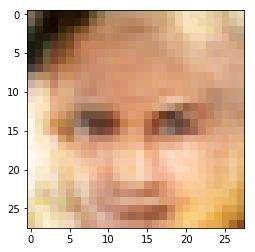

231.0
Epoch 1/1... Discriminator Loss: 1.2021... Generator Loss: 1.2723
232.0
Epoch 1/1... Discriminator Loss: 0.4283... Generator Loss: 1.3200
233.0
Epoch 1/1... Discriminator Loss: 0.7209... Generator Loss: 1.1795
234.0
Epoch 1/1... Discriminator Loss: 0.6556... Generator Loss: 6.6627
235.0
Epoch 1/1... Discriminator Loss: 0.6074... Generator Loss: 1.9928
236.0
Epoch 1/1... Discriminator Loss: 0.5832... Generator Loss: 1.2445
237.0
Epoch 1/1... Discriminator Loss: 1.1392... Generator Loss: 0.5904
238.0
Epoch 1/1... Discriminator Loss: 0.6706... Generator Loss: 1.2592
239.0
Epoch 1/1... Discriminator Loss: 3.4283... Generator Loss: 3.4810
240.0
Epoch 1/1... Discriminator Loss: 1.1359... Generator Loss: 0.9015


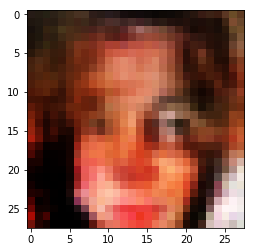

241.0
Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.4278
242.0
Epoch 1/1... Discriminator Loss: 1.0689... Generator Loss: 0.6837
243.0
Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.3759
244.0
Epoch 1/1... Discriminator Loss: 0.8655... Generator Loss: 0.9453
245.0
Epoch 1/1... Discriminator Loss: 0.7931... Generator Loss: 1.7443
246.0
Epoch 1/1... Discriminator Loss: 1.2644... Generator Loss: 1.5340
247.0
Epoch 1/1... Discriminator Loss: 1.0196... Generator Loss: 0.8163
248.0
Epoch 1/1... Discriminator Loss: 1.6640... Generator Loss: 0.3212
249.0
Epoch 1/1... Discriminator Loss: 1.1653... Generator Loss: 0.5561
250.0
Epoch 1/1... Discriminator Loss: 1.1597... Generator Loss: 0.6038


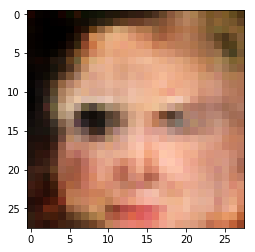

251.0
Epoch 1/1... Discriminator Loss: 1.0573... Generator Loss: 0.7407
252.0
Epoch 1/1... Discriminator Loss: 0.6833... Generator Loss: 2.6368
253.0
Epoch 1/1... Discriminator Loss: 1.2277... Generator Loss: 0.4689
254.0
Epoch 1/1... Discriminator Loss: 1.1576... Generator Loss: 0.6275
255.0
Epoch 1/1... Discriminator Loss: 0.7361... Generator Loss: 1.7768
256.0
Epoch 1/1... Discriminator Loss: 1.5318... Generator Loss: 1.2492
257.0
Epoch 1/1... Discriminator Loss: 0.9573... Generator Loss: 1.0396
258.0
Epoch 1/1... Discriminator Loss: 1.2499... Generator Loss: 1.8179
259.0
Epoch 1/1... Discriminator Loss: 1.0925... Generator Loss: 1.0179
260.0
Epoch 1/1... Discriminator Loss: 0.8561... Generator Loss: 1.0907


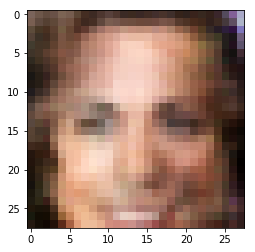

261.0
Epoch 1/1... Discriminator Loss: 1.2835... Generator Loss: 1.3359
262.0
Epoch 1/1... Discriminator Loss: 0.9944... Generator Loss: 0.7974
263.0
Epoch 1/1... Discriminator Loss: 1.1072... Generator Loss: 0.5609
264.0
Epoch 1/1... Discriminator Loss: 0.1586... Generator Loss: 4.7933
265.0
Epoch 1/1... Discriminator Loss: 0.3129... Generator Loss: 3.2637
266.0
Epoch 1/1... Discriminator Loss: 0.6044... Generator Loss: 1.5101
267.0
Epoch 1/1... Discriminator Loss: 1.1265... Generator Loss: 5.1472
268.0
Epoch 1/1... Discriminator Loss: 1.8549... Generator Loss: 0.2520
269.0
Epoch 1/1... Discriminator Loss: 1.2402... Generator Loss: 0.4702
270.0
Epoch 1/1... Discriminator Loss: 1.0361... Generator Loss: 0.7532


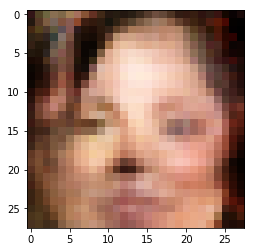

271.0
Epoch 1/1... Discriminator Loss: 1.1718... Generator Loss: 0.5694
272.0
Epoch 1/1... Discriminator Loss: 1.0223... Generator Loss: 0.6045
273.0
Epoch 1/1... Discriminator Loss: 0.8239... Generator Loss: 1.0559
274.0
Epoch 1/1... Discriminator Loss: 0.3763... Generator Loss: 3.1107
275.0
Epoch 1/1... Discriminator Loss: 1.6724... Generator Loss: 0.3253
276.0
Epoch 1/1... Discriminator Loss: 1.1533... Generator Loss: 0.6309
277.0
Epoch 1/1... Discriminator Loss: 0.8960... Generator Loss: 1.8447
278.0
Epoch 1/1... Discriminator Loss: 1.4793... Generator Loss: 0.3793
279.0
Epoch 1/1... Discriminator Loss: 1.4094... Generator Loss: 0.4105
280.0
Epoch 1/1... Discriminator Loss: 0.9518... Generator Loss: 0.7598


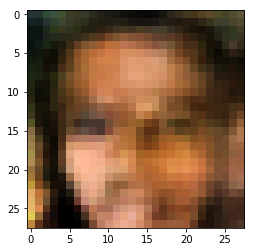

281.0
Epoch 1/1... Discriminator Loss: 0.8647... Generator Loss: 0.8890
282.0
Epoch 1/1... Discriminator Loss: 1.4204... Generator Loss: 0.4215
283.0
Epoch 1/1... Discriminator Loss: 0.9871... Generator Loss: 2.4777
284.0
Epoch 1/1... Discriminator Loss: 0.8623... Generator Loss: 1.8531
285.0
Epoch 1/1... Discriminator Loss: 0.5439... Generator Loss: 1.5604
286.0
Epoch 1/1... Discriminator Loss: 0.2363... Generator Loss: 2.3125
287.0
Epoch 1/1... Discriminator Loss: 0.2697... Generator Loss: 3.5717
288.0
Epoch 1/1... Discriminator Loss: 1.1556... Generator Loss: 0.4842
289.0
Epoch 1/1... Discriminator Loss: 0.6470... Generator Loss: 1.7443
290.0
Epoch 1/1... Discriminator Loss: 0.9719... Generator Loss: 0.7273


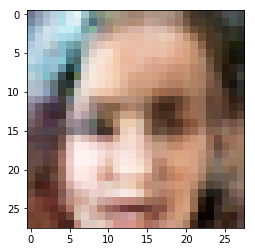

291.0
Epoch 1/1... Discriminator Loss: 0.9482... Generator Loss: 0.7470
292.0
Epoch 1/1... Discriminator Loss: 0.1423... Generator Loss: 6.6957
293.0
Epoch 1/1... Discriminator Loss: 2.5281... Generator Loss: 3.0378
294.0
Epoch 1/1... Discriminator Loss: 0.9788... Generator Loss: 1.0956
295.0
Epoch 1/1... Discriminator Loss: 1.4668... Generator Loss: 1.8272
296.0
Epoch 1/1... Discriminator Loss: 0.9835... Generator Loss: 0.9988
297.0
Epoch 1/1... Discriminator Loss: 0.8549... Generator Loss: 1.4111
298.0
Epoch 1/1... Discriminator Loss: 1.1135... Generator Loss: 0.5700
299.0
Epoch 1/1... Discriminator Loss: 0.9790... Generator Loss: 0.7727
300.0
Epoch 1/1... Discriminator Loss: 0.6158... Generator Loss: 1.4022


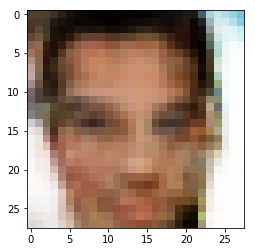

301.0
Epoch 1/1... Discriminator Loss: 1.6316... Generator Loss: 0.2912
302.0
Epoch 1/1... Discriminator Loss: 0.9979... Generator Loss: 0.7703
303.0
Epoch 1/1... Discriminator Loss: 1.5959... Generator Loss: 0.3538
304.0
Epoch 1/1... Discriminator Loss: 0.7739... Generator Loss: 1.1927
305.0
Epoch 1/1... Discriminator Loss: 1.0613... Generator Loss: 0.6896
306.0
Epoch 1/1... Discriminator Loss: 1.0165... Generator Loss: 0.6764
307.0
Epoch 1/1... Discriminator Loss: 0.9632... Generator Loss: 0.9910
308.0
Epoch 1/1... Discriminator Loss: 0.7147... Generator Loss: 1.6579
309.0
Epoch 1/1... Discriminator Loss: 1.7565... Generator Loss: 1.5139
310.0
Epoch 1/1... Discriminator Loss: 0.8821... Generator Loss: 2.8597


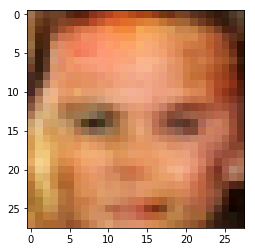

311.0
Epoch 1/1... Discriminator Loss: 1.6969... Generator Loss: 0.2768
312.0
Epoch 1/1... Discriminator Loss: 1.1452... Generator Loss: 0.6267
313.0
Epoch 1/1... Discriminator Loss: 1.0400... Generator Loss: 1.2184
314.0
Epoch 1/1... Discriminator Loss: 1.0984... Generator Loss: 1.8242
315.0
Epoch 1/1... Discriminator Loss: 0.9190... Generator Loss: 1.1362
316.0
Epoch 1/1... Discriminator Loss: 1.0864... Generator Loss: 1.4763


In [13]:
# batch_size = None
batch_size = 64
# z_dim = None
z_dim = 64
# learning_rate = None
learning_rate = 0.001
# beta1 = None
beta1 = 0.2

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.